# Eigenfaces

Reference: https://github.com/svetlana-topalova/eigenfaces

In [197]:
%matplotlib inline
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

### 1. Read Images

In [198]:
IMAGE_DIR = 'faces'
DEFAULT_SIZE = [250, 250] 

def read_images(image_path=IMAGE_DIR, default_size=DEFAULT_SIZE):
    images = []
    images_names = []
    image_dirs = [image for image in os.listdir(image_path) if not image.startswith('.')]
    for image_dir in image_dirs:
        dir_path = os.path.join(image_path, image_dir)
        image = Image.open (dir_path)
        image = image.convert ("L")
        # resize to given size (if given )
        if (default_size is not None ):
            image = image.resize (default_size , Image.ANTIALIAS )
        images.append(np.asarray (image , dtype =np. uint8 ))
        images_names.append(image_dir[0:-4])
    return [images,images_names]

### Assemble Data Matrix

We turn the image from a $n\times n$ matrix to a vector of length $n^2$

In [199]:
def as_row_matrix (X):
    if len (X) == 0:
        return np. array ([])
    mat = np. empty ((0 , X [0].size ), dtype =X [0]. dtype )
    for row in X:
        mat = np.vstack(( mat , np.asarray( row ).reshape(1 , -1))) # 1 x r*c 
    return mat

### Compute the mean face $\mu$

The mean vector consists of the means of each variable and the variance-covariance matrix consists of the variances of the variables along the main diagonal and the covariances between each pair of variables in the other matrix positions.

The average of the image set is calculated as:
<img src="mean_face_formula.png" />

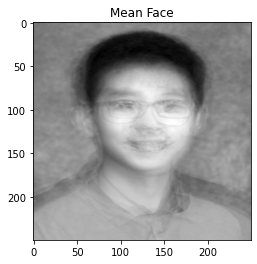

In [200]:
[X, y] = read_images()      
average_weight_matrix = np.reshape(as_row_matrix(X).mean( axis =0), X[0].shape)
plt.imshow(average_weight_matrix, cmap=plt.cm.gray)
plt.title("Mean Face")
plt.show()

### Calculate PCA (Principal Component Analysis)
We define function `pca` to caluclate it in the following steps:

1. Subtract the mean. The average image a has to be subtracted from each original image in X.
2. Calculate the eigenvectors and eigenvalues of the covariance matrix S.

<img src="covariance_matrix.png" />

Compute the eigenvalues $\lambda_{i}$ and eigenvectors $v_{i}$ of S

<img src="eigenvalues.png" />

Each eigenvector has the same dimensionality (number of components) as the original images, and thus can itself be seen as an image.

3. Choose the principal components

Sorting the eigenvalues with `np.argsort` in descending order and arrange eigenvectors accordingly. The number of principal components k is determined arbitrarily by setting a threshold ε on the total variance. Total variance is ${\displaystyle v=n\cdot (\lambda _{1}+\lambda _{2}+...+\lambda _{n})}$, so we find the smallest k that satisfies:

${\displaystyle {\frac {n(\lambda _{1}+\lambda _{2}+...+\lambda _{k})}{v}}>\epsilon } $

We calculate it with function `get_number_of_components_to_preserve_variance` for variance=0.99.

The k principal components of the observed vector x are then given by:

$y = W^{T} (x - \mu)$

where

$W = (v_{1}, v_{2}, \ldots, v_{k})$. 


In [201]:
def get_number_of_components_to_preserve_variance(eigenvalues, variance=.99):
    for ii, eigen_value_cumsum in enumerate(np.cumsum(eigenvalues) / np.sum(eigenvalues)):
        if eigen_value_cumsum > variance:
            return ii
def pca (X, y, num_components =0):
    [n,d] = X.shape
    if ( num_components <= 0) or ( num_components >n):
        num_components = n
        mu = X.mean( axis =0)
        X = X - mu
    if n>d:
        C = np.dot(X.T,X) # Covariance Matrix
        [ eigenvalues , eigenvectors ] = np.linalg.eigh(C)
    else :
        C = np.dot (X,X.T) # Covariance Matrix
        [ eigenvalues , eigenvectors ] = np.linalg.eigh(C)
        eigenvectors = np.dot(X.T, eigenvectors )
        for i in range (n):
            eigenvectors [:,i] = eigenvectors [:,i]/ np.linalg.norm( eigenvectors [:,i])
    # sort eigenvectors descending by their eigenvalue
    idx = np.argsort (- eigenvalues )
    eigenvalues = eigenvalues [idx ]
    eigenvectors = eigenvectors [:, idx ]
    num_components = get_number_of_components_to_preserve_variance(eigenvalues)
    # select only num_components
    eigenvalues = eigenvalues [0: num_components ].copy ()
    eigenvectors = eigenvectors [: ,0: num_components ].copy ()
    return [ eigenvalues , eigenvectors , mu]  

[eigenvalues, eigenvectors, mean] = pca (as_row_matrix(X), y)

We use our data set of images to calculate the least amount of eigenfaces to satisfy the variance threshold.

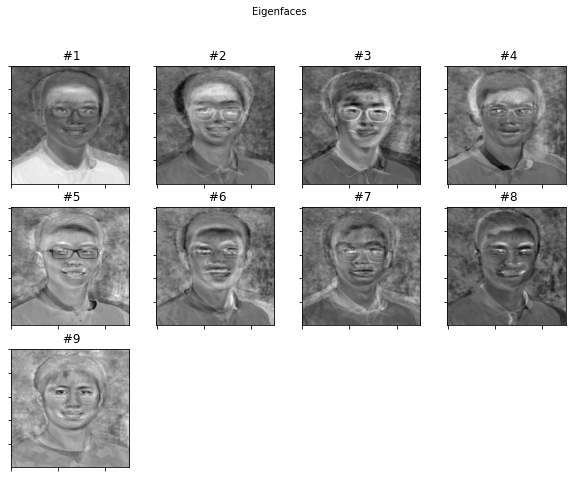

In [202]:
def subplot ( title , images , rows , cols , sptitle ="", sptitles =[] , colormap = plt.cm.gray, filename = None, figsize = (10, 10) ):
    fig = plt.figure(figsize = figsize)
    # main title
    fig.text (.5 , .95 , title , horizontalalignment ="center")
    for i in range ( len ( images )):
        ax0 = fig.add_subplot( rows , cols ,( i +1))
        plt.setp ( ax0.get_xticklabels() , visible = False )
        plt.setp ( ax0.get_yticklabels() , visible = False )
        if len ( sptitles ) == len ( images ):
            plt.title("%s #%s" % ( sptitle , str ( sptitles [i ]) )  )
        else:
            plt.title("%s #%d" % ( sptitle , (i +1) )  )
        plt.imshow(np.asarray(images[i]) , cmap = colormap )
    if filename is None :
        plt.show()
    else:
        fig.savefig( filename )

        
E = []
number = eigenvectors.shape[1]
for i in range (min(number, 16)):
    e = eigenvectors[:,i].reshape(X[0].shape )
    E.append(np.asarray(e))
# plot them and store the plot to " python_eigenfaces .pdf"
subplot ( title ="Eigenfaces", images=E, rows =4, cols =4, colormap =plt.cm.gray, filename='python_pca_eigenfaces.png')

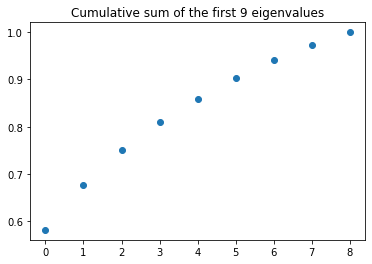

In [203]:
def get_eigen_value_distribution(eigenvectors):
    return np.cumsum(eigenvectors) / np.sum(eigenvectors)

def plot_eigen_value_distribution(eigenvectors, interval):
    plt.scatter(interval, get_eigen_value_distribution(eigenvectors)[interval])

plot_eigen_value_distribution(eigenvalues, range(0, number))
plt.title("Cumulative sum of the first {0} eigenvalues".format(number))
plt.show()

### Least-Squares
$Ax = b$

$x = (A^{T}A)^{-1}A^{T}b$

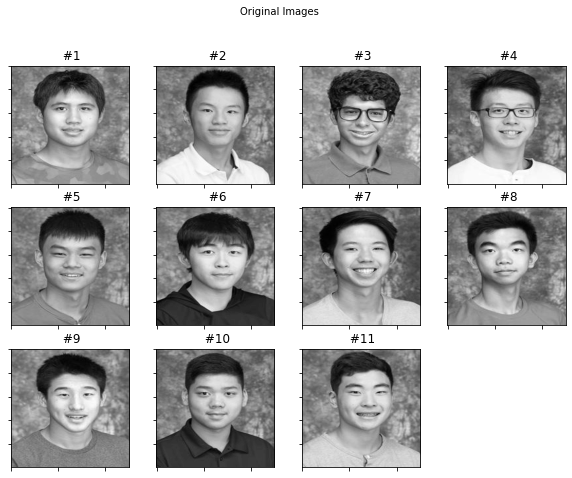

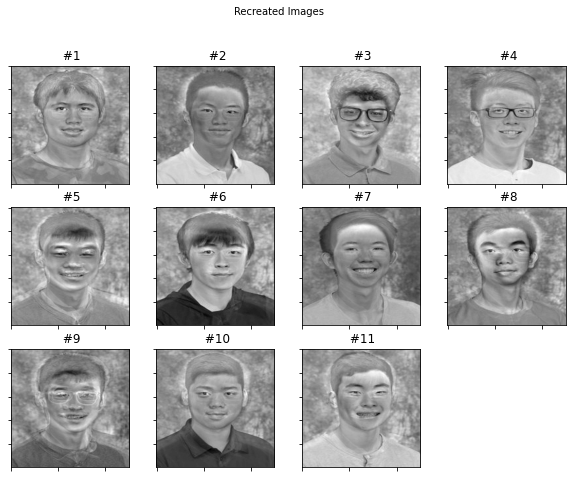

In [204]:
recreated_images = []
for b in as_row_matrix(X):
    x = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(eigenvectors), eigenvectors)), np.transpose(eigenvectors)), b-mean)
    b_hat = np.matmul(eigenvectors, x)
    img = b_hat.reshape(X[0].shape )
    recreated_images.append(img)

subplot ( title ="Original Images", images=X, rows=4, cols=4, colormap=plt.cm.gray)
subplot ( title ="Recreated Images", images=recreated_images, rows =4, cols =4, colormap =plt.cm.gray, filename="recreated_images.png")


### Gram–Schmidt process
Given a basis $\{x_{1},...,x_{p}\}$ for a subspace $W$ of $R^{n}$ define

$v_{1}=x_{1}$

$v_{2}=x_{2}-(\frac{x_2.v_1}{v_1.v_1})v_1$

$v_{3}=x_{3}-(\frac{x_3.v_1}{v_1.v_1})v_1-(\frac{x_3.v_2}{v_2.v_2})v_1$

$v_{p}=x_{p}-\sum_{k=1}^{p-1}(\frac{x_p.v_k}{v_k.v_k})v_k$

Then $\{v_1,...,v_p\}$ is an orthogonal basis for $W$.

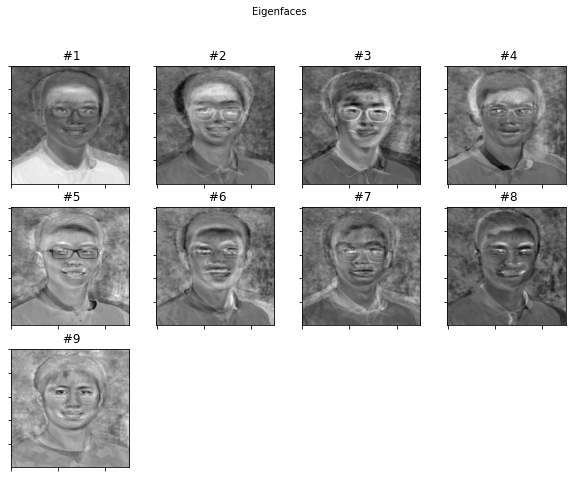

In [205]:
v = []
x = np.transpose(eigenvectors)
for p in range(len(x)):
    vp = x[p]
    for k in range(p):
        vp -= (np.dot(x[p],v[k])/np.dot(v[k],v[k]))*v[k]
    v.append(vp)
v /= np.linalg.norm(v)
v = np.transpose(np.asarray(v))

E = []
number = v.shape[1]
for i in range (min(number, 16)):
    e = v[:,i].reshape(X[0].shape )
    E.append(np.asarray(e))
# plot them and store the plot to " python_eigenfaces .pdf"
subplot ( title ="Eigenfaces", images=E, rows =4, cols =4, colormap =plt.cm.gray, filename='orthogonalized_eigenfaces.png')

### Face Recognition using Eigenfaces
Now we use the algorithm for face detection in an unknown image In the recognition process, an eigenface is formed for the given face image, and the Euclidian distances between this eigenface and the previously stored eigenfaces are calculated. The eigenface with the smallest Euclidian distance is the one the person resembles the most.

Face recognition performed by:

1. Projecting all training samples into the PCA subspace.
2. Projecting the query image into the PCA subspace.
3. Finding the nearest neighbor between the projected training images and the projected query image.

The Euclidean distance between points p and q is the length of the line segment connecting them.

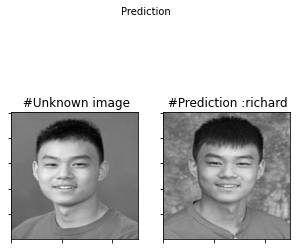

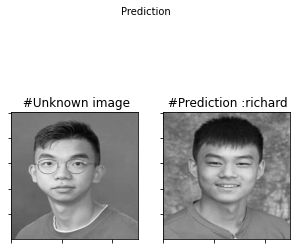

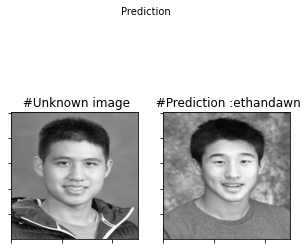

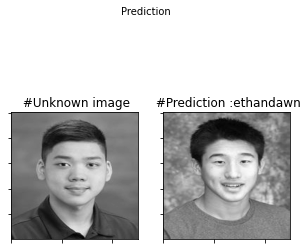

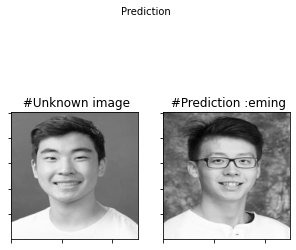

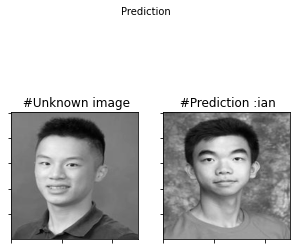

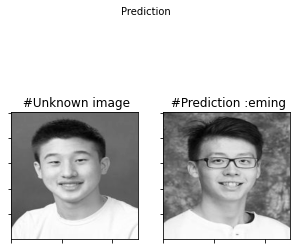

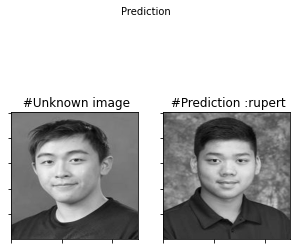

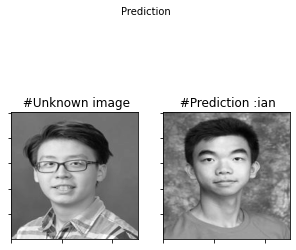

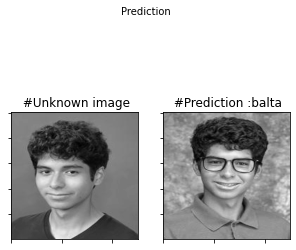

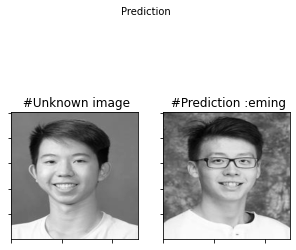

In [212]:
def project(b, eigenvectors):
    return np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(eigenvectors), eigenvectors)), np.transpose(eigenvectors)), b)

def dist_metric(p,q):
    p = np.asarray(p).flatten()
    q = np.asarray (q).flatten()
    return np.sqrt (np.sum (np. power ((p-q) ,2)))

def predict (W, projections, y, b):
    minDist = float("inf")
    minClass = -1
    Q = project (b,v)
    for i in range (len(projections)):
        dist = dist_metric( projections[i], Q)
        if dist < minDist:
            minDist = dist
            minClass = i
    return minClass

projections = []
for b in as_row_matrix(X):
    projections.append(project(b-mean, v))

[X_tests, y_tests] = read_images(image_path="tests")

for i in range(len(X_tests)):
    predicted = predict(eigenvectors , projections, y, X_tests[i].reshape(-1) - mean)
    subplot ( title ="Prediction", images =[X_tests[i], X[predicted]], rows =1, cols =2, 
         sptitles = ["Unknown image", "Prediction :{0}".format(y[predicted])] , colormap =plt.cm.gray, filename=f'predictions/prediction_{i}.png', figsize = (5,5))
